In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data = pd.read_csv("final.csv", encoding="latin-1")
data["Industry_encoded"] = le.fit_transform(data['Industry'])
data["Industry"] = data["Industry"].astype("category")
data["cluster"] = data["cluster"].astype("category")
data = data.drop(columns=["Unnamed: 0","cluster","Industry"])
# data.info()
# print(data.head)
# data = data.drop(columns=["cluster"])

In [18]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
# Set up 5-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
# Loop over each fold for cross-validation
fold_metrics = []
fold_counter = 1
X = data.drop(columns=["Yt.1M"])
y = data["Yt.1M"]
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Initialize the XGBoost regressor.
    # n_estimators, learning_rate, and max_depth can be tuned further.
    model = XGBRegressor(n_estimators=200, booster="gbtree", learning_rate=0.1, max_depth=5,
    random_state=42, objective='reg:squarederror')
    # Fit the model on training data
    model.fit(X_train, y_train)
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    fold_metrics.append({
    'Fold': fold_counter,
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae
    })
    # Output feature importances for the current fold
    # print(f"\nFold {fold_counter} Feature Importances:")
    # print(model.feature_importances_)
    # Output performance metrics for the current fold
    print(f"Fold {fold_counter} -- MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    fold_counter += 1

Fold 1 -- MSE: 0.0114, RMSE: 0.1066, MAE: 0.0668
Fold 2 -- MSE: 0.0225, RMSE: 0.1500, MAE: 0.0850
Fold 3 -- MSE: 0.0211, RMSE: 0.1452, MAE: 0.0761
Fold 4 -- MSE: 0.0158, RMSE: 0.1257, MAE: 0.0799
Fold 5 -- MSE: 0.0115, RMSE: 0.1071, MAE: 0.0716


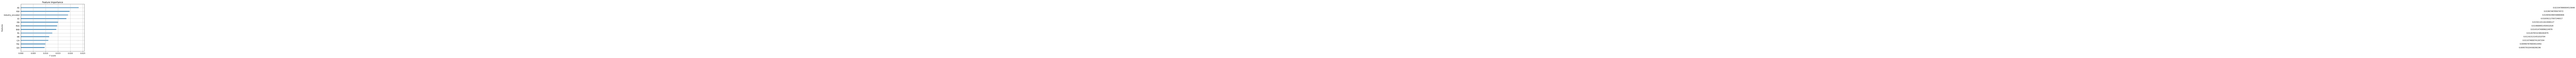

In [10]:
xgb.plot_importance(model, importance_type="gain")
plt.title("Feature Importance")
plt.show()

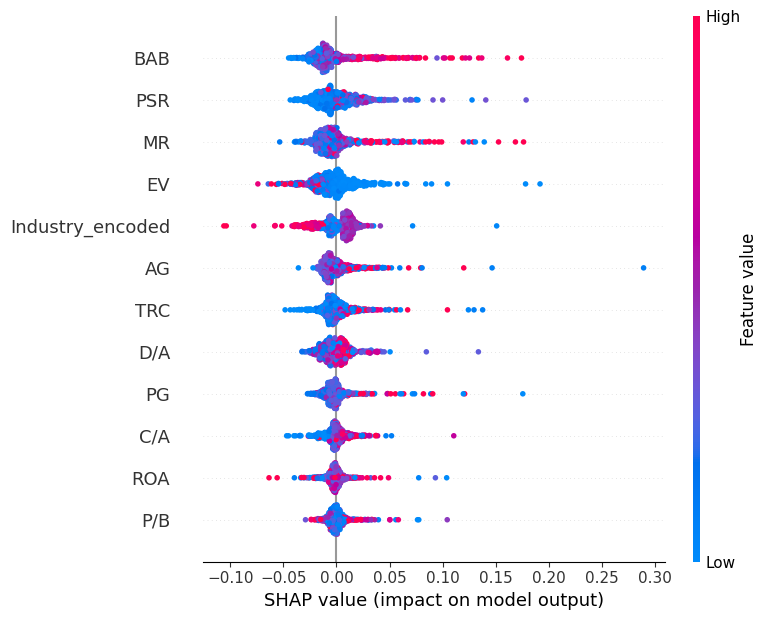

In [11]:
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

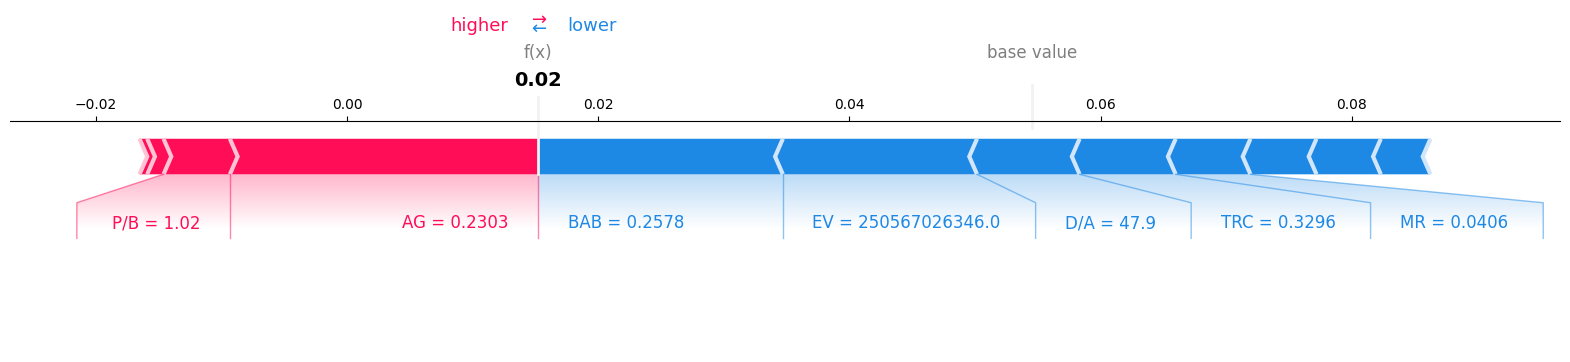

In [13]:
shap.plots.force(shap_values[0],matplotlib=True)
print(

In [52]:
def objective(trial):
    params = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "enable_categorical":True,
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
    }
    fold_rmse_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # Initialize the XGBoost regressor.
        # n_estimators, learning_rate, and max_depth can be tuned further.
        model = XGBRegressor(**params)
        # Fit the model on training data
        model.fit(X_train, y_train)
        # Make predictions on the test data
        y_pred = model.predict(X_test)
        # Compute evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        fold_rmse_list += [rmse]
    return np.asanyarray(fold_rmse_list).mean()

In [55]:
import optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000)  # you can increase n_trials

[I 2025-04-13 00:13:03,016] A new study created in memory with name: no-name-30a634d1-7662-4dde-95d1-ebb7cb91a4e1
[I 2025-04-13 00:13:03,452] Trial 0 finished with value: 0.1254078163292362 and parameters: {'max_depth': 8, 'learning_rate': 0.20001120588696594, 'n_estimators': 345, 'subsample': 0.7199180958462985, 'colsample_bytree': 0.5691695946136754, 'gamma': 3.5519081094162845, 'lambda': 1.5479664545091123, 'alpha': 8.501377192978238}. Best is trial 0 with value: 0.1254078163292362.
[I 2025-04-13 00:13:04,108] Trial 1 finished with value: 0.1253822224936771 and parameters: {'max_depth': 6, 'learning_rate': 0.08392514729868157, 'n_estimators': 544, 'subsample': 0.7361409635819989, 'colsample_bytree': 0.8680615153665103, 'gamma': 2.2273239893002734, 'lambda': 1.6825002036352583, 'alpha': 0.010028283098747587}. Best is trial 1 with value: 0.1253822224936771.
[I 2025-04-13 00:13:04,601] Trial 2 finished with value: 0.12540760362794146 and parameters: {'max_depth': 3, 'learning_rate': 0.

In [56]:
# optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_optimization_history(study).show()